**Following are what the columns represent**

 - credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
 - purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
 - int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
 - installment: The monthly installments owed by the borrower if the loan is funded.
 - log.annual.inc: The natural log of the self-reported annual income of the borrower.
 - dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
 - fico: The FICO credit score of the borrower.
 - days.with.cr.line: The number of days the borrower has had a credit line.
 - revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
 - revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
 - inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
 - delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
 - pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

## Loading data

**Import the data, play around with it and understand the structure**

In [25]:
# import packages we will use
import numpy as np
import pandas as pd
import io

# packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# split data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model evaluation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc

# save model
from sklearn.externals import joblib

In [2]:
# help functions
# help function to plot learning curve for model evaluation
def Plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, y,
                                                            cv = cv,
                                                            n_jobs = n_jobs,
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    # shows error from 0.8 to 0.9
    plt.ylim(.8,.9)
    plt.show()
    return
  
# help function to plot ROC curve for randomforest
def ROC_Curve(rf, X_test, y_test):
    y_predicted = rf.predict_proba(X_test)[:, 1]   # prob of positive class
    false_positive, true_positive, _ = roc_curve(y_test, y_predicted)
    
    auc = roc_auc_score(y_test, rf.predict(X_test))

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.2f)' % auc)
    plt.legend(loc='best')
    plt.show()
    return
    
# help function to report accuracy
def Report_accuracy(model, y_test, y_predictions):
    ntotal = len(y_test)
    correct = y_test == y_predictions
    numCorrect = sum(correct)
    percent = round((100.0*numCorrect)/ntotal, 6)
    print("\nCorrect classifications on test data: {0:d}/{1:d} {2:8.3f}%".format(numCorrect, ntotal, percent))
    prediction_score = 100.0*model.score(X_test, y_test)
    print('Prediction Score on test data: %8.3f' % prediction_score)
    return

In [3]:
# load the loan data
data = pd.read_csv('dataset/loan_data.csv')

# quick look at the data
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [4]:
print('\n Shape of loan data:', data.shape)


 Shape of loan data: (9578, 14)


In [5]:
# get a quick description of the data
data.info()

print("\n Thers's one categorical feature need to be converted")
print("\n All features have 9578 non-null value, so we don't need worry about missing value")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB

 Thers's one categorical feature need to be converted

 All features have 9578 non-null value, so we don't need worry about missing value


In [6]:
# check missing value
data.isna().any()

credit.policy        False
purpose              False
int.rate             False
installment          False
log.annual.inc       False
dti                  False
fico                 False
days.with.cr.line    False
revol.bal            False
revol.util           False
inq.last.6mths       False
delinq.2yrs          False
pub.rec              False
not.fully.paid       False
dtype: bool

In [7]:
# statistics summary of the numerical variables
data.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [8]:
# see the information of the categorical data
data.describe(include=['O'])

,purpose
count,9578
unique,7
top,debt_consolidation
freq,3957


## Exploratory Data Analysis

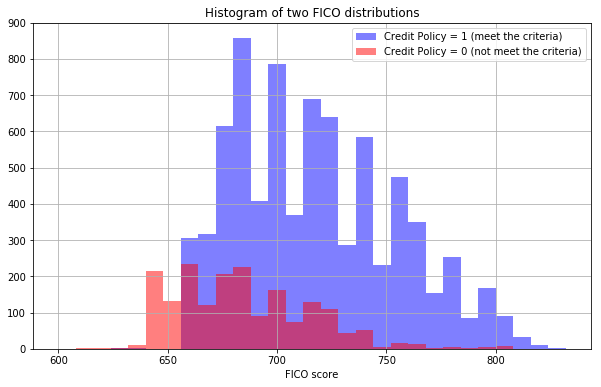

In [9]:
# create a histogram of two FICO distribuitons for each group for credit.policy
bin_values = np.arange(start=600, stop=840, step=8)
plt.figure(figsize=(10,6))
data[data['credit.policy']==1]['fico'].hist(bins=bin_values, grid=True, color='blue', alpha=0.5, label='Credit Policy = 1 (meet the criteria)')
data[data['credit.policy']==0]['fico'].hist(bins=bin_values, grid=True, color='red', alpha=0.5, label='Credit Policy = 0 (not meet the criteria)')
plt.legend()
plt.title("Histogram of two FICO distributions")
plt.xlabel("FICO score")
plt.show()

Customers who have credit score below around 660 are unlikely to meet the criteria. The overlap part indicates that some customers don't meet the criteria even though they have high credit score.

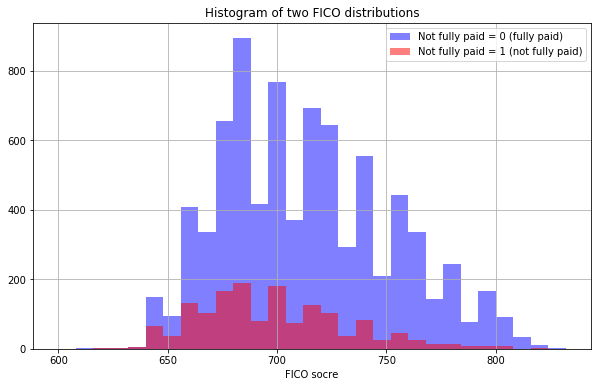

In [10]:
# creat a histogram for not.fully.paid for each group of not.fully paid 
plt.figure(figsize=(10,6))
data[data['not.fully.paid']==0]['fico'].hist(bins=bin_values, grid=True, color='blue', alpha=0.5, label='Not fully paid = 0 (fully paid)')
data[data['not.fully.paid']==1]['fico'].hist(bins=bin_values, grid=True, color='red', alpha=0.5, label='Not fully paid = 1 (not fully paid)')
plt.legend()
plt.title("Histogram of two FICO distributions")
plt.xlabel("FICO socre")
plt.show()

The two histograms overlap a lot. High credit score doesn't guarantee  fully paid.

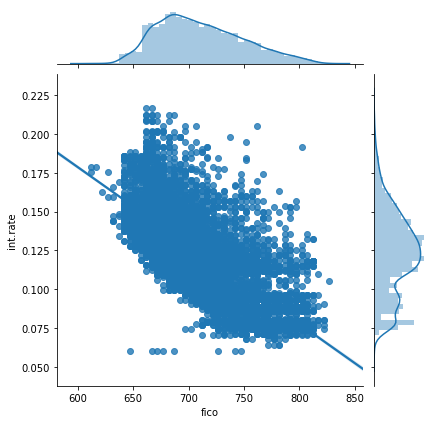

In [11]:
# create jointplot for FICO score and interest rate
sns.jointplot(x='fico', y='int.rate', data=data, kind='reg')
plt.show()

 From the jiontplot we can see that there's a linear trend between FICO score and interest rate. The interest rate has a trend of decrease, as the FICO score increases. The Pearson correlation coefficient is -0.71, indicating a negative linear relationship between FICO score and interest rate. 

The two features are highly correlated with each other, we can drop one of them when do features selection.

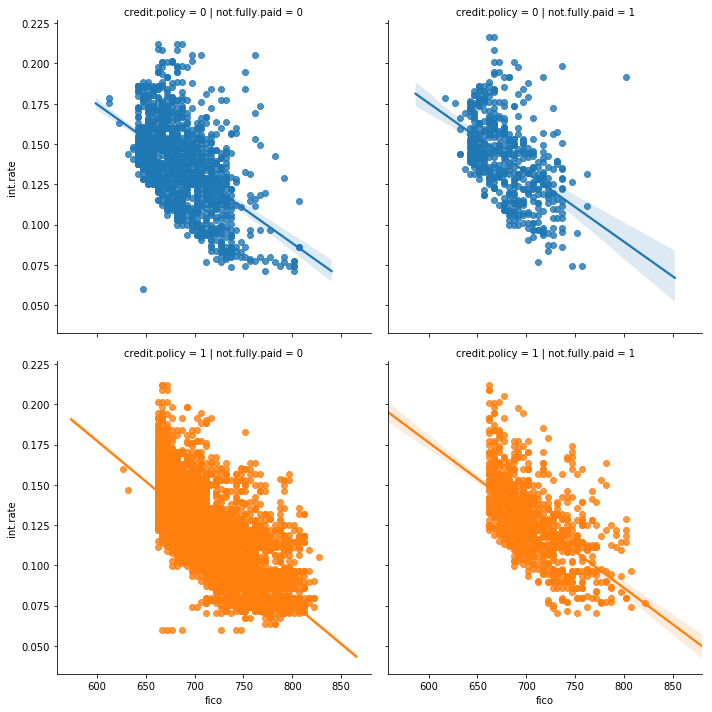

In [12]:
sns.lmplot(x='fico', y='int.rate', data=data, row='credit.policy', col='not.fully.paid', hue='credit.policy')
plt.show()

From the plot we can see that the linear trend doesn't change across different level combinations.

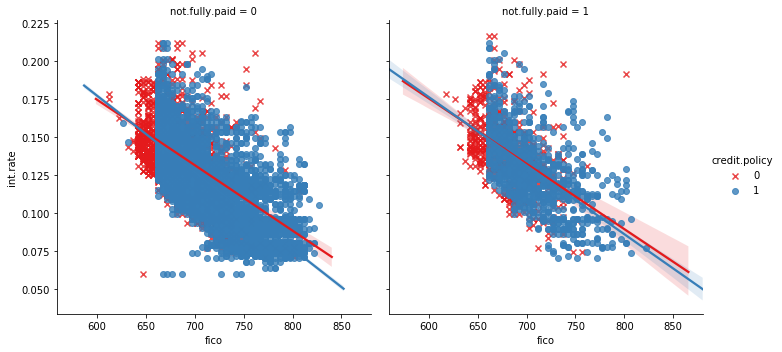

In [13]:
sns.lmplot(x='fico', y='int.rate', data=data, hue='credit.policy', col='not.fully.paid', markers=["x", "o"],
          palette='Set1')
plt.show()

# Preprocessing data

In [14]:
# see if probability of meeting the criteria differ across different level of purpose
purpose = data[['purpose', 'credit.policy']].groupby(['purpose'], as_index=False).mean().sort_values(
    by='credit.policy', ascending=False)   # if as_index=True, return object with group labels as the index
purpose

,purpose,credit.policy
5,major_purchase,0.848970
2,debt_consolidation,0.814506
4,home_improvement,0.813990
1,credit_card,0.808241
6,small_business,0.799677
0,all_other,0.787216
3,educational,0.740525


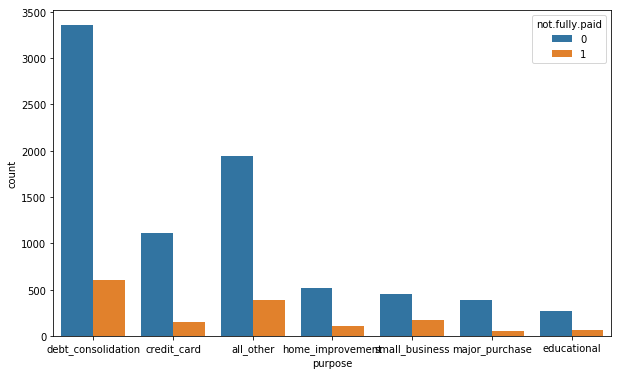

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(x='purpose', data=data, hue='not.fully.paid')
plt.show()

In [16]:
# use 1hot encoding to create dummy varaible for 'purpose'
data = pd.get_dummies(data,columns=['purpose'], drop_first=True)
data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [17]:
# stratify split based on 'not.fully.paid', drop 'int.rate' because it is highly correlated with 'fico'
X = data.drop(['not.fully.paid', 'int.rate'], axis=1)
y = data['not.fully.paid'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42, shuffle=True)

In [18]:
# see the proportion of two outcomes in test data, and it shoud be similar with the porportion in the training data
y_test.value_counts()/len(y_test)

0    0.839944
1    0.160056
Name: not.fully.paid, dtype: float64

In [19]:
# train Decision Tree model
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_pred_train = tree.predict(X_train)

tree_mse_train = mean_squared_error(y_train, tree_pred_train)
print('\n The misclassification error of training set is :', tree_mse_train)

tree_pred_test = tree.predict(X_test)

tree_mse_test = mean_squared_error(y_test, tree_pred_test)
print('\n The misclassification error of test set is :', tree_mse_test)


 The misclassification error of training set is : 0.0

 The misclassification error of test set is : 0.2595685455810717


The misclassification error of test set is 0.26 while training set is 0, which indicates a overfitting. 

In [20]:
# create confusion matrix
print(classification_report(y_test, tree_pred_test))

print('Confusion Matrix for test data:')
print(confusion_matrix(y_test, tree_pred_test))

# report accuracy
Report_accuracy(tree, y_test, tree_pred_test)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2414
           1       0.22      0.25      0.24       460

   micro avg       0.74      0.74      0.74      2874
   macro avg       0.54      0.54      0.54      2874
weighted avg       0.75      0.74      0.75      2874

Confusion Matrix for test data:
[[2013  401]
 [ 345  115]]

Correct classifications on test data: 2128/2874   74.043%
Prediction Score on test data:   74.043


# Training a Random Forest Model

 - Create an instance of the random forest model and fit it into the above training model


In [21]:
# train random forest using 5-fold corss-validation
randomforest = RandomForestClassifier(class_weight='balanced', random_state=42)
randomforest.fit(X_train,y_train)

forest_scores = cross_val_score(randomforest, X_train, y_train, scoring='neg_mean_squared_error', cv=5) 

rf_mse_train = np.mean(-forest_scores)
print('\n The misclassification error of training set is :', rf_mse_train)

rf_pred_test = randomforest.predict(X_test)

rf_mse_test = mean_squared_error(y_test, rf_pred_test)
print('\n The misclassification error of test set is :', rf_mse_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



 The misclassification error of training set is : 0.1646784350418397

 The misclassification error of test set is : 0.16562282533054976


In [130]:
# create confusion matrix
print(classification_report(y_test, rf_pred_test))

print('Confusion Matrix for test data:')
print(confusion_matrix(y_test, rf_pred_test))

# report accuracy
Report_accuracy(randomforest, y_test, rf_pred_test)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2414
           1       0.31      0.03      0.05       460

   micro avg       0.83      0.83      0.83      2874
   macro avg       0.58      0.51      0.48      2874
weighted avg       0.76      0.83      0.77      2874

Confusion Matrix for test data:
[[2385   29]
 [ 447   13]]

Correct classifications on test data: 2398/2874   83.438%
Prediction Score on test data:   83.438


The performace of random forest is much better than a decision tree. But the precision and recall are very bad. 

I will use grid search to optimize tuning parameters for random forest.

In [0]:
# GridSearchCV for random forest
param_grid = [
    {'n_estimators': [10,50,100,200], 'max_features': ['sqrt',2,4,6], 'max_depth': [1,3,5,8],
    'min_samples_leaf': [3,5,10]} 
]

forest_cla = RandomForestClassifier()
grid_search = GridSearchCV(forest_cla, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 50, 100, 200], 'max_features': ['sqrt', 2, 4, 6], 'max_depth': [1, 3, 5, 8], 'min_samples_leaf': [3, 5, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [0]:
print('\n Best estimator:')
print(grid_search.best_estimator_)


 Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [0]:
final_model = grid_search.best_estimator_
final_pred_train = final_model.predict(X_train)

final_mse = mean_squared_error(y_train, final_pred_train)
print('\n The misclassification error of training data is :', final_mse)


 The misclassification error of training data is : 0.15542959427207637


## Predictions and Evaluation

Let's predict off the y_test values and evaluate our model.

In [0]:
final_pred_test = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_pred_test)
print('\n The misclassification error of test data is :', final_mse)


 The misclassification error of test data is : 0.1593597773138483


In [0]:
# save model using joblib
joblib.dump(final_model, 'rf_grid.pkl')

# load model 
rf_loaded = joblib.load('rf_grid.pkl')

In [0]:
# report the feature importances
# Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node.
# The node probability can be calculated by the number of samples that reach the node, 
# divided by the total number of samples. The higher the value the more important the feature.
sorted(zip(final_model.feature_importances_, list(X_train.columns)), reverse=True)  # features importance sums to 1

[(0.14404741320499154, 'inq.last.6mths'),
 (0.12358784083066372, 'installment'),
 (0.12075246840247152, 'revol.util'),
 (0.10627881480973556, 'log.annual.inc'),
 (0.10578856623044755, 'days.with.cr.line'),
 (0.10109177232720294, 'fico'),
 (0.07853588128891546, 'dti'),
 (0.07313437147136727, 'credit.policy'),
 (0.07143226031347584, 'revol.bal'),
 (0.03749605684844912, 'purpose_small_business'),
 (0.010926204854951747, 'purpose_credit_card'),
 (0.0071360862074348885, 'pub.rec'),
 (0.006755333080467936, 'purpose_debt_consolidation'),
 (0.0059212098929695865, 'delinq.2yrs'),
 (0.003244142492500439, 'purpose_home_improvement'),
 (0.0025305298754143154, 'purpose_educational'),
 (0.0013410478685406076, 'purpose_major_purchase')]

In [0]:
info = np.round(100*np.sum(final_model.feature_importances_[0:9]), 2)
print('\n The most 9 important features include', info, '% information of data.')


 The most 9 important features include 92.46 % information of data.


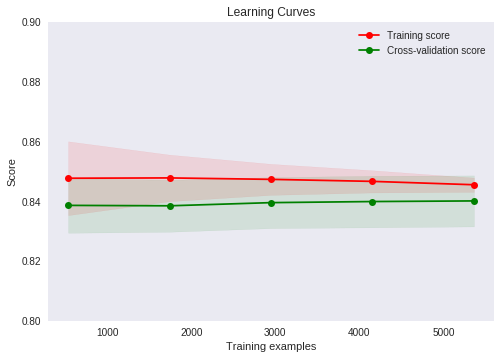

In [0]:
# Cross validation with 100 iterations (100-fold) to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
Plot_learning_curve(final_model, 'Learning Curves', X_train, y_train, cv = cv, n_jobs = 1)

The slight decrease of training score indicates a underfitting. The cross-validation score stagnates throughout, which indicates the classifier is unable to learn from the data.

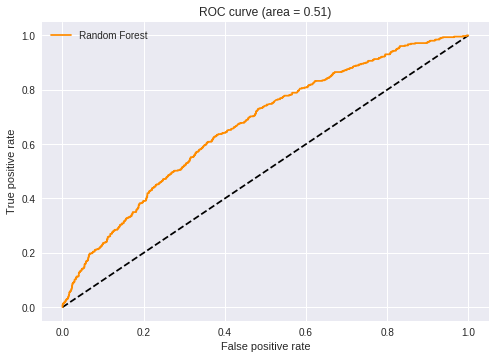

In [0]:
# ROC curve 
ROC_Curve(final_model, X_test, y_test)

**Create a classification report from the results**

In [0]:
print(classification_report(y_test, final_pred_test))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2414
           1       0.58      0.02      0.03       460

   micro avg       0.84      0.84      0.84      2874
   macro avg       0.71      0.51      0.47      2874
weighted avg       0.80      0.84      0.77      2874



**Show the confusion Matrix for the predictions**

In [131]:
print('Confusion Matrix for test data:')
print(confusion_matrix(y_test, final_pred_test))

# report accuracy
Report_accuracy(final_model, y_test, final_pred_test)

Confusion Matrix for test data:
[[2409    5]
 [ 453    7]]

Correct classifications on test data: 2416/2874   84.064%
Prediction Score on test data:   84.064


**Provide a brief explanation of your findings**
- What performed better and why ?
- If you feel neither perfomed good, list down reasons 

Random forest is much better than decision tree. One important reason is that a decision tree without pruning suffers from high variance. However, random forest can reduce the variance  by training many decision trees on a random subset of features, then averaging their predictions. Based on the result, we can see that the classification accuracy improves from 74% to 84%. Even though recall becomes worse, precision improves. 


Neither of the two methods performed good. The reasons are:

*   Having unbalanced  data. The majority customers are fully paid (class 0), and 16% customers are not fully paid (class 1).
*   Decision tree suffers from high variance (training mse is 0, while test mse is 0.26)
*   Random forest successfully reduces the variance, but the learning curve indicates it has a problem of high bias (underfitting). 
*   We may need more information (useful features) to fit model. From the learning curve, we can see the cross-validation score stagnating throughout, which indicates the classifier is unable to learn from the data. Actually, many features have relative feature importance below 0.01,  which are useless for model fitting. In addtion, the performance of random forest improves a little (from 83% to 84%) after grid search. Optimizing tuning parameters doesn't help to get a better model, which indicates we need improve model by getting more information.

How to improve prediction:

*   Data part: Get more data,  especially more features because random forest suffers from a underfitting. If we aren't able to get more data, we can do feature engineer such as create a useful one by combining some of the features. 
*   Model part: Try other methods such as logistic regression, SVM, and create a voting classifier composed of diverse classifiers to aggregate the predictions of each classifier, and predict the class that gets the most votes.






**For the following part, I implement resampling methods to deal with the imbalanced data and try different ML algorithms such as Boosting and Neural Network.**

## Improving Random Forest
#### Improve randomforest by using 'balanced bootstrap' to deal with imbalanced  data.

In [486]:
X = data.drop(['not.fully.paid'], axis=1).copy()
y = data['not.fully.paid'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    normalize(X), y.values, stratify=y, test_size = 0.3, random_state = 42, shuffle=True)

# GridSearchCV for random forest
param_grid = [
    {'n_estimators': [10,50,100,200], 'max_features': ['sqrt',2,4,6], 'max_depth': [1,3,5,8],
    'min_samples_leaf': [3,5,10]} 
]

forest_cla = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)
grid_search = GridSearchCV(forest_cla, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print('\n Best estimator:')
print(grid_search.best_estimator_)


 Best estimator:
RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=8, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)


In [487]:
final_model = grid_search.best_estimator_
final_pred_train = final_model.predict(X_train)

final_mse = mean_squared_error(y_train, final_pred_train)
print('\n The misclassification error of training data is :', final_mse)

final_pred_test = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_pred_test)
print('\n The misclassification error of test data is :', final_mse)


 The misclassification error of training data is : 0.1731801909307876

 The misclassification error of test data is : 0.2522616562282533


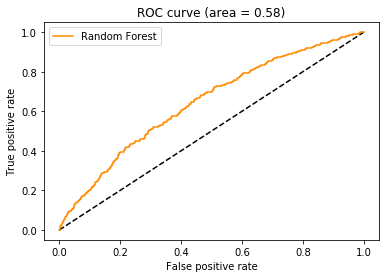

In [488]:
# ROC curve 
ROC_Curve(final_model, X_test, y_test)

In [489]:
print(classification_report(y_test, final_pred_test))

print('Confusion Matrix for test data:')
print(confusion_matrix(y_test, final_pred_test))

# report accuracy
Report_accuracy(final_model, y_test, final_pred_test)

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2414
           1       0.27      0.33      0.29       460

   micro avg       0.75      0.75      0.75      2874
   macro avg       0.57      0.58      0.57      2874
weighted avg       0.77      0.75      0.76      2874

Confusion Matrix for test data:
[[1999  415]
 [ 310  150]]

Correct classifications on test data: 2149/2874   74.774%
Prediction Score on test data:   74.774


## Random Forest, Boosting and Neural network on Under sampling data


 Counts for class 0 and class 1 are:  6436 1226

 Random under-sampling:
1    1226
0    1226
Name: not.fully.paid, dtype: int64

 The misclassification error of training set is : 0.3849858967977434

 The misclassification error of test set is : 0.40866388308977036
              precision    recall  f1-score   support

           0       0.89      0.59      0.71      1609
           1       0.22      0.60      0.32       307

   micro avg       0.59      0.59      0.59      1916
   macro avg       0.55      0.60      0.51      1916
weighted avg       0.78      0.59      0.65      1916


 Confusion Matrix for test data:
[[948 661]
 [122 185]]

Correct classifications on test data: 1133/1916   59.134%
Prediction Score on test data:   59.134


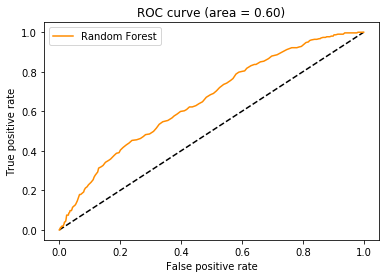

In [26]:
# under sampling
data_under = data.copy()

X_under = data_under.drop(['not.fully.paid'], axis=1).copy()
y_under = data_under['not.fully.paid'].copy()

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X_under, y_under, stratify=y_under, test_size = 0.2, random_state = 42, shuffle=True)

X_under = pd.concat([X_train, y_train], axis=1)

count_class_0, count_class_1 = X_under['not.fully.paid'].value_counts()
print('\n Counts for class 0 and class 1 are: ', count_class_0, count_class_1)

# Divide by class
class_0 = X_under[X_under['not.fully.paid'] == 0]
class_1 = X_under[X_under['not.fully.paid'] == 1]

class_0_under = class_0.sample(count_class_1, replace=False)
X_train_under = pd.concat([class_1, class_0_under], axis=0)

print('\n Random under-sampling:')
print(X_train_under['not.fully.paid'].value_counts())

X_train_under = shuffle(X_train_under, random_state=42)

X_train = X_train_under.drop(['not.fully.paid'], axis=1)
y_train = X_train_under['not.fully.paid'].copy()

# train random forest using 5-fold corss-validation
randomforest = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', random_state=42,
                                     max_features='sqrt')
randomforest.fit(X_train,y_train)

forest_scores = cross_val_score(randomforest, X_train, y_train, scoring='neg_mean_squared_error', cv=5) 

rf_mse_train = np.mean(-forest_scores)
print('\n The misclassification error of training set is :', rf_mse_train)

rf_pred_test = randomforest.predict(X_test)

rf_mse_test = mean_squared_error(y_test, rf_pred_test)
print('\n The misclassification error of test set is :', rf_mse_test)

# create confusion matrix
print(classification_report(y_test, rf_pred_test))

print('\n Confusion Matrix for test data:')
print(confusion_matrix(y_test, rf_pred_test))

# report accuracy
Report_accuracy(randomforest, y_test, rf_pred_test)

# ROC curve 
ROC_Curve(randomforest, X_test, y_test)


 The misclassification error of training set is : 0.08523654159869494

 The misclassification error of test set is : 0.4003131524008351
              precision    recall  f1-score   support

           0       0.89      0.60      0.72      1609
           1       0.22      0.61      0.33       307

   micro avg       0.60      0.60      0.60      1916
   macro avg       0.56      0.60      0.52      1916
weighted avg       0.78      0.60      0.65      1916


 Confusion Matrix for test data:
[[963 646]
 [121 186]]

Correct classifications on test data: 1149/1916   59.969%
Prediction Score on test data:   59.969


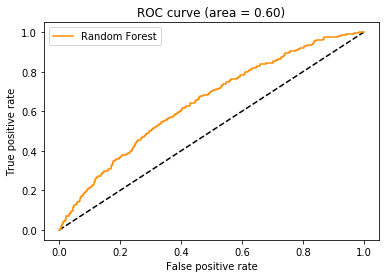

In [27]:
from xgboost import XGBClassifier
xgb_cla = XGBClassifier(n_estimators=300, random_state=42, max_depth=8, learning_rate=0.01)
# Add silent=True to avoid printing out updates with each cycle
xgb_cla.fit(X_train, y_train)

xgb_pred_train = xgb_cla.predict(X_train)
xgb_mse_train = mean_squared_error(y_train, xgb_pred_train)
print('\n The misclassification error of training set is :', xgb_mse_train)

xgb_pred_test = xgb_cla.predict(X_test)

xgb_mse_test = mean_squared_error(y_test, xgb_pred_test)
print('\n The misclassification error of test set is :', xgb_mse_test)

# create confusion matrix
print(classification_report(y_test, xgb_pred_test))

print('\n Confusion Matrix for test data:')
print(confusion_matrix(y_test, xgb_pred_test))

# report accuracy
Report_accuracy(xgb_cla, y_test, xgb_pred_test)

# ROC curve 
ROC_Curve(xgb_cla, X_test, y_test)

Epoch 1/5
2452/2452 [==============================] - 2s 871us/step - loss: 0.7002 - acc: 0.5175
Epoch 2/5
2452/2452 [==============================] - 0s 155us/step - loss: 0.6711 - acc: 0.5803
Epoch 3/5
2452/2452 [==============================] - 0s 147us/step - loss: 0.6566 - acc: 0.6085
Epoch 4/5
2452/2452 [==============================] - 0s 149us/step - loss: 0.6432 - acc: 0.6289
Epoch 5/5
1916/1916 [==============================] - 1s 470us/step

 Test accuracy: 0.5918580374538526

 The misclassification error of training data is : 0.35522022838499184

 The misclassification error of test data is : 0.4081419624217119
              precision    recall  f1-score   support

           0       0.90      0.57      0.70      1609
           1       0.23      0.68      0.35       307

   micro avg       0.59      0.59      0.59      1916
   macro avg       0.57      0.63      0.53      1916
weighted avg       0.80      0.59      0.65      1916

Confusion Matrix for test data:
[[924

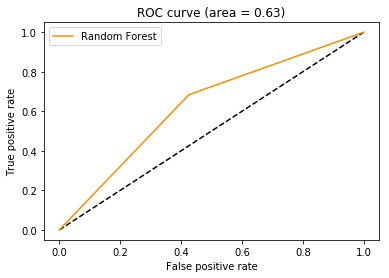

In [597]:
# data standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# build model
model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# compile model
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit model
model.fit(X_train, y_train.values, epochs=5)

# predict test value
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\n Test accuracy:', test_acc)

# model evaluation and confusion matrix
model_pred_train = model.predict(X_train)
model_pred_train = (model_pred_train > 0.5)

model_mse = mean_squared_error(y_train, model_pred_train)
print('\n The misclassification error of training data is :', model_mse)

model_pred_test = model.predict(X_test)
model_pred_test = (model_pred_test > 0.5)

model_mse = mean_squared_error(y_test, model_pred_test)
print('\n The misclassification error of test data is :', model_mse)

print(classification_report(y_test, model_pred_test))

print('Confusion Matrix for test data:')
print(confusion_matrix(y_test, model_pred_test))

# ROC Curve
false_positive, true_positive, _ = roc_curve(y_test, model_pred_test)
    
auc = roc_auc_score(y_test, (model.predict(X_test) > 0.5))

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='Neural Network')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc)
plt.legend(loc='best')
plt.show()

## Random Forest, Boosting and Neural network on Over sampling data


 Counts for class 0 and class 1 are:  6436 1226

 Random over-sampling:
1    6436
0    6436
Name: not.fully.paid, dtype: int64
(12872, 18) (12872,)

 The misclassification error of training set is : 0.3691727958032306

 The misclassification error of test set is : 0.3178496868475992
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1609
           1       0.26      0.51      0.34       307

   micro avg       0.68      0.68      0.68      1916
   macro avg       0.57      0.61      0.57      1916
weighted avg       0.78      0.68      0.72      1916


 Confusion Matrix for test data:
[[1149  460]
 [ 149  158]]

Correct classifications on test data: 1307/1916   68.215%
Prediction Score on test data:   68.215


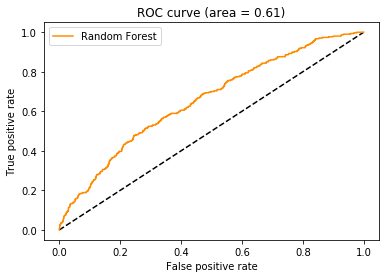

In [28]:
# over sampling
data_over = data.copy()

X_over = data_over.drop(['not.fully.paid'], axis=1).copy()
y_over = data_over['not.fully.paid'].copy()

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X_over, y_over, stratify=y_over, test_size = 0.2, random_state = 42, shuffle=True)

X_over = pd.concat([X_train, y_train], axis=1)

count_class_0, count_class_1 = X_over['not.fully.paid'].value_counts()
print('\n Counts for class 0 and class 1 are: ', count_class_0, count_class_1)

# Divide by class
class_0 = X_over[X_over['not.fully.paid'] == 0]
class_1 = X_over[X_over['not.fully.paid'] == 1]

class_1_over = class_1.sample(count_class_0, replace=True, random_state=42)  # the duplicate data
        
X_train_over = pd.concat([class_0, class_1_over], axis=0)

print('\n Random over-sampling:')
print(X_train_over['not.fully.paid'].value_counts())

X_train_over = shuffle(X_train_over, random_state=42)

X_train = X_train_over.drop(['not.fully.paid'], axis=1)
y_train = X_train_over['not.fully.paid']

print(X_train.shape, y_train.shape)

# train random forest using 5-fold corss-validation
randomforest = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample', random_state=42,
                                      max_depth=3)
randomforest.fit(X_train,y_train)

forest_scores = cross_val_score(randomforest, X_train, y_train, scoring='neg_mean_squared_error', cv=5) 

rf_mse_train = np.mean(-forest_scores)
print('\n The misclassification error of training set is :', rf_mse_train)

rf_pred_test = randomforest.predict(X_test)

rf_mse_test = mean_squared_error(y_test, rf_pred_test)
print('\n The misclassification error of test set is :', rf_mse_test)

# create confusion matrix
print(classification_report(y_test, rf_pred_test))

print('\n Confusion Matrix for test data:')
print(confusion_matrix(y_test, rf_pred_test))

# report accuracy
Report_accuracy(randomforest, y_test, rf_pred_test)

# ROC curve 
ROC_Curve(randomforest, X_test, y_test)


 The misclassification error of training set is : 0.3662989434431324

 The misclassification error of test set is : 0.3246346555323591
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1609
           1       0.25      0.52      0.34       307

   micro avg       0.68      0.68      0.68      1916
   macro avg       0.57      0.61      0.56      1916
weighted avg       0.78      0.68      0.71      1916


 Confusion Matrix for test data:
[[1134  475]
 [ 147  160]]

Correct classifications on test data: 1294/1916   67.537%
Prediction Score on test data:   67.537


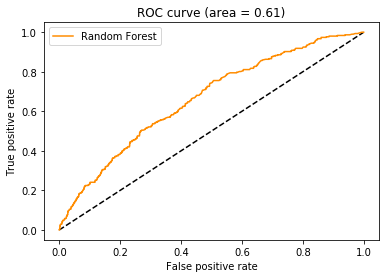

In [29]:
from xgboost import XGBClassifier
xgb_cla = XGBClassifier(n_estimators=300, random_state=42, max_depth=2, learning_rate=0.01)
# Add silent=True to avoid printing out updates with each cycle
xgb_cla.fit(X_train, y_train)

xgb_pred_train = xgb_cla.predict(X_train)
xgb_mse_train = mean_squared_error(y_train, xgb_pred_train)
print('\n The misclassification error of training set is :', xgb_mse_train)

xgb_pred_test = xgb_cla.predict(X_test)

xgb_mse_test = mean_squared_error(y_test, xgb_pred_test)
print('\n The misclassification error of test set is :', xgb_mse_test)

# create confusion matrix
print(classification_report(y_test, xgb_pred_test))

print('\n Confusion Matrix for test data:')
print(confusion_matrix(y_test, xgb_pred_test))

# report accuracy
Report_accuracy(xgb_cla, y_test, xgb_pred_test)

# ROC curve 
ROC_Curve(xgb_cla, X_test, y_test)

Epoch 1/5
12872/12872 [==============================] - 4s 285us/step - loss: 0.6496 - acc: 0.6107
Epoch 2/5
12872/12872 [==============================] - 2s 142us/step - loss: 0.6241 - acc: 0.6448
Epoch 3/5
12872/12872 [==============================] - 2s 144us/step - loss: 0.6140 - acc: 0.6569
Epoch 4/5
12872/12872 [==============================] - 2s 154us/step - loss: 0.6037 - acc: 0.6652
Epoch 5/5
1916/1916 [==============================] - 1s 501us/step

 Test accuracy: 0.623695198578725

 The misclassification error of training data is : 0.3144033561218148

 The misclassification error of test data is : 0.3763048016701461
              precision    recall  f1-score   support

           0       0.90      0.62      0.74      1609
           1       0.24      0.63      0.35       307

   micro avg       0.62      0.62      0.62      1916
   macro avg       0.57      0.62      0.54      1916
weighted avg       0.79      0.62      0.67      1916

Confusion Matrix for test data:

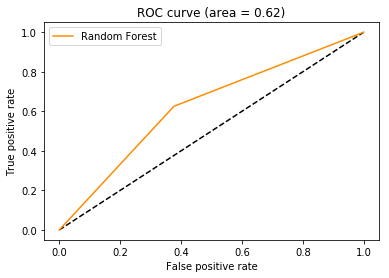

In [600]:
# data standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# build model
model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# compile model
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit model
model.fit(X_train, y_train.values, epochs=5)

# predict test value
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\n Test accuracy:', test_acc)

# model evaluation and confusion matrix
model_pred_train = model.predict(X_train)
model_pred_train = (model_pred_train > 0.5)

model_mse = mean_squared_error(y_train, model_pred_train)
print('\n The misclassification error of training data is :', model_mse)

model_pred_test = model.predict(X_test)
model_pred_test = (model_pred_test > 0.5)

model_mse = mean_squared_error(y_test, model_pred_test)
print('\n The misclassification error of test data is :', model_mse)

print(classification_report(y_test, model_pred_test))

print('Confusion Matrix for test data:')
print(confusion_matrix(y_test, model_pred_test))

# ROC Curve
false_positive, true_positive, _ = roc_curve(y_test, model_pred_test)
    
auc = roc_auc_score(y_test, (model.predict(X_test) > 0.5))

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='Neural Network')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = %0.2f)' % auc)
plt.legend(loc='best')
plt.show()

As a result, the model performance has a big improvement in terms of Recall (improves from 0.02 to 0.68) and ROC curve (AUC value increase from 0.51 to 0.63)! Let's just assume only lending money to customers who will not be fully paid cost the company. Therefore, company cares more about the recall, which is the fraction model correctly detects as not fully paid in total number of not fully paid. Neural network model on under sampling data gave us a recall of 0.68, which means it correctly detected 68% people who are not fully paid. 